# Simulated Data

This notebook runs simulations to evaluate graph-based methods on both unattributed and attributed graphs (200 nodes, 5 balanced classes).  

Note that the total computation time for all simulations (100 repetitions for each combination of parameters × method) can be long, but should not exceed 1 hour.  

The resulting data (stored as method–parameters–external evaluation) are saved in a `data` folder within the environment directory, which is created automatically if it does not already exist.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shortuuid

from tqdm import tqdm
from math import ceil

from src.simulation.graph import SimulatedGraph
from src.evaluation.testing import SimpleGraphTesting

from src.simulation.graph import SimulatedAttributedGraph
from src.evaluation.testing import AttributedGraphTesting

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Non-Attributed Graph

In [2]:
def fair_division(n, k):
    base = n // k
    reste = n % k
    parts = [base + 1 if i < reste else base for i in range(k)]
    return np.array(parts)

In [3]:
# Parameters
k = 5
n = 200
groups = fair_division(n,k)
type_graph = ["ref","sparse","chain","donut","star"]
rep_iter = 100

structure_list = np.geomspace(0.5, 5, num=10).round(1)

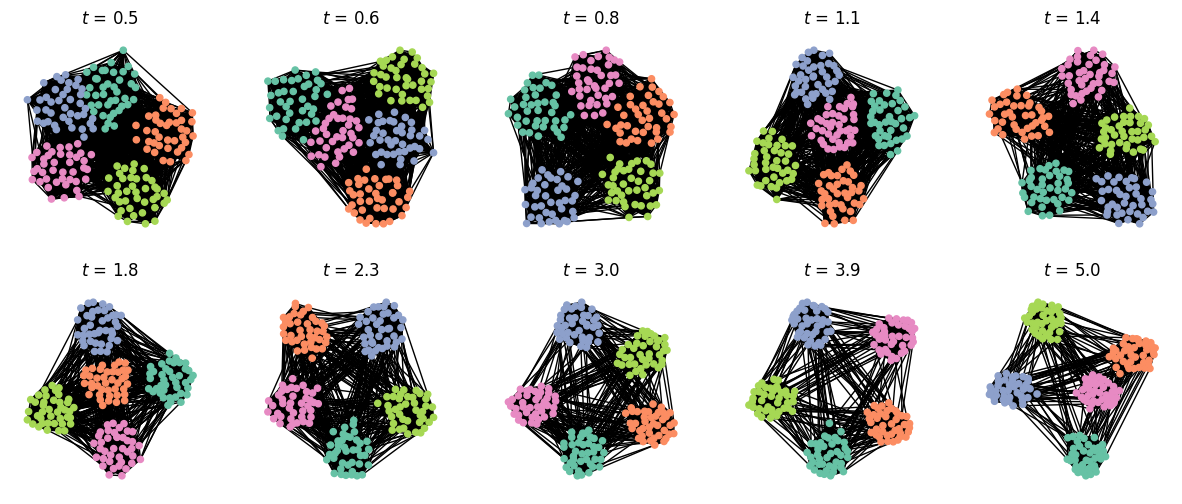

In [4]:
import seaborn as sns
sns.set_context("notebook", font_scale=1)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, structure in enumerate(structure_list):
    graph = SimulatedGraph(groups, type_graph="ref", structure_strength=structure)
    graph.plot(ax = axes[i])
    axes[i].set_title(f"$t$ = {structure}")

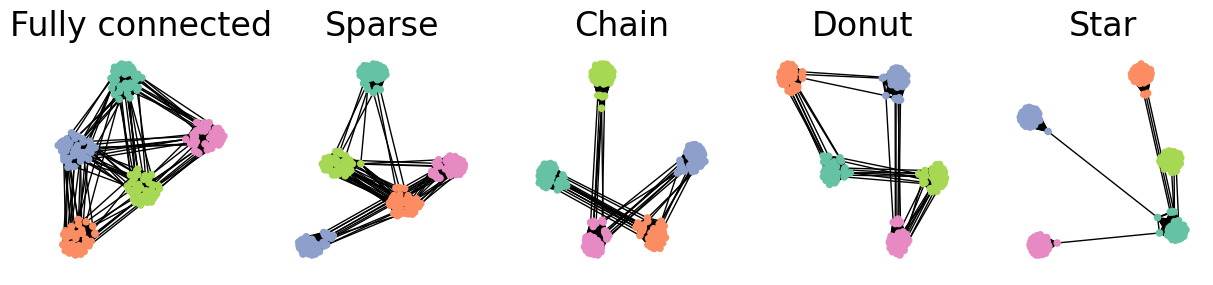

In [5]:
import seaborn as sns
sns.set_context("notebook", font_scale=2)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.flatten()
title_dict = {'ref':'Fully connected',
              'sparse': 'Sparse', 
              'chain': 'Chain',
              'donut': 'Donut',
              'star': 'Star'}
for i, t_graph in enumerate(type_graph):
    graph = SimulatedGraph(groups, type_graph=t_graph, structure_strength=10)
    graph.plot(ax = axes[i])
    axes[i].set_title(title_dict[t_graph])

In [ ]:
infos = {"id": shortuuid.uuid(),
         "scenario": "non attributed graph"}
print(infos['id'])

for structure_force in tqdm(structure_list):
    for t in type_graph:
        infos['type_graph'] = t
        #infos['repartition'] = group
        
        parameters = {'structure_force' : np.repeat([structure_force],rep_iter)}
        simulated_graph = SimulatedGraph(groups=groups,
                                         type_graph=t,
                                         structure_strength=structure_force)
        true_labels = simulated_graph.get_true_labels()
        distance_graph, mixing_matrices = simulated_graph.test_structure_force(parameters['structure_force'], type_graph=t, fixed=True)

        evaluation = SimpleGraphTesting(n,k,parameters=parameters)
        evaluation.testing_simple(distance_graph,
                                  infos = infos,
                                  mixing_matrix = mixing_matrices,
                                  true_labels= true_labels,
                                  save = True)

# Attributed Graph

In [6]:
# Parameters Graph
k = 5
n = 200
equilibre=20
alpha = 0.5
type_graph = "ref"

In [ ]:
# Parameters Attributes & Simulation
medoid = True
infos = {"id": shortuuid.uuid(),
         "scenario": "attributed graph",
         "equilibre": equilibre,
         "type_graph": type_graph,
         "medoid": medoid}
rep = 100
rep_iter = ceil(rep**(1/3))

structure_list = np.geomspace(0.1, 10, num=10).round(1)
c_list = [1000,200,80,15,2]
epsilon_list = [0.05, 0.15, 0.2, 0.35, 2]

In [8]:
# FGW config
weights = {"hist":0.5, "fun":0.5}
powers = {"hist":2, "fun":2}
fgw_config = {'weights':weights,
              'powers':powers}
groups = fair_division(n,k)
infos['groups'] = groups

In [ ]:
print(infos['id'])
simulated_graph = SimulatedAttributedGraph(k = k, groups=groups)
true_labels = simulated_graph.get_true_labels()
for structure_force in tqdm(structure_list[2:]): 
        for perturbation in range(len(c_list)):
            parameters = {'structure_force' : np.repeat([structure_force],rep),
                          'c' : np.repeat([c_list[perturbation]],rep),
                          'epsilon' : np.repeat([epsilon_list[perturbation]],rep)}
                        
            distance_graph, _ = simulated_graph.test_structure_force(parameters['structure_force'], type_graph=type_graph)
            """
            distances_hist, _ = simulated_graph.test_c(parameters['c'])
            distance_attributes_dict = [{"hist": hist} for hist in distances_hist]
            """
            distance_attributes, distances_hist, distances_fun, _, _ = simulated_graph.test_c_epsilon(parameters['c'],
                                                                                                      parameters['epsilon'],
                                                                                                      product=False)                                                                                          
            distance_attributes_dict = [{"hist": hist, "fun": fun} for hist, fun in zip(distances_hist, distances_fun)]
            
            # Evaluation
            evaluation = AttributedGraphTesting(n=n, k=k, parameters=parameters)
            evaluation.testing_attributed(distance_graph,
                                          distance_attributes_dict,
                                          infos = infos,
                                          fgw_config=fgw_config,
                                          true_labels=true_labels,
                                          save=True,
                                          medoid=True)